In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Load data

In [ ]:
data = pd.read_csv("./epoch_training_time.csv")# deucalion data
figname='deucalion.pdf'

#data = pd.read_csv("./Finisterrae_times.csv")# Finisterrae 3 data
#figname='finisterrae.pdf'

#data = pd.read_csv("./RTX3090_times.csv")# RTX 3090 data
#figname='RTX3090.pdf'

In [43]:
# Get the three series, dense, venom and venom with no transposition
if "mean" in data.columns:
    time_column = "mean"
    gpus = 4
elif "total_milliseconds" in data.columns:
    gpus = 2
    time_column = "total_milliseconds"


dense = data[data['name'] == 'dense'].groupby(['bs'])[time_column].mean().reset_index(name="step_time_mean")
venom = data[data['name'] == 'venom'].groupby(['bs'])[time_column].mean().reset_index(name="step_time_mean")
venom_no_transpose = data[data['name'] == 'venom_no_transpose'].groupby(['bs'])[time_column].mean().reset_index(name="step_time_mean")
batch_sizes = data['bs'].sort_values( ascending=True).unique()

#print('batch sizes:', batch_sizes)
#print('Dense times:', dense)
#print('VENOM times:\n', venom)
#print('VENOM no transpose times:\n', venom_no_transpose)


# Create a DataFrame
df = pd.DataFrame({
    'Batch Size': batch_sizes,
    'Dense': dense['step_time_mean'],
    'VENOM': venom['step_time_mean'],
    'VENOM w/o transpose': venom_no_transpose['step_time_mean']
}).set_index('Batch Size')



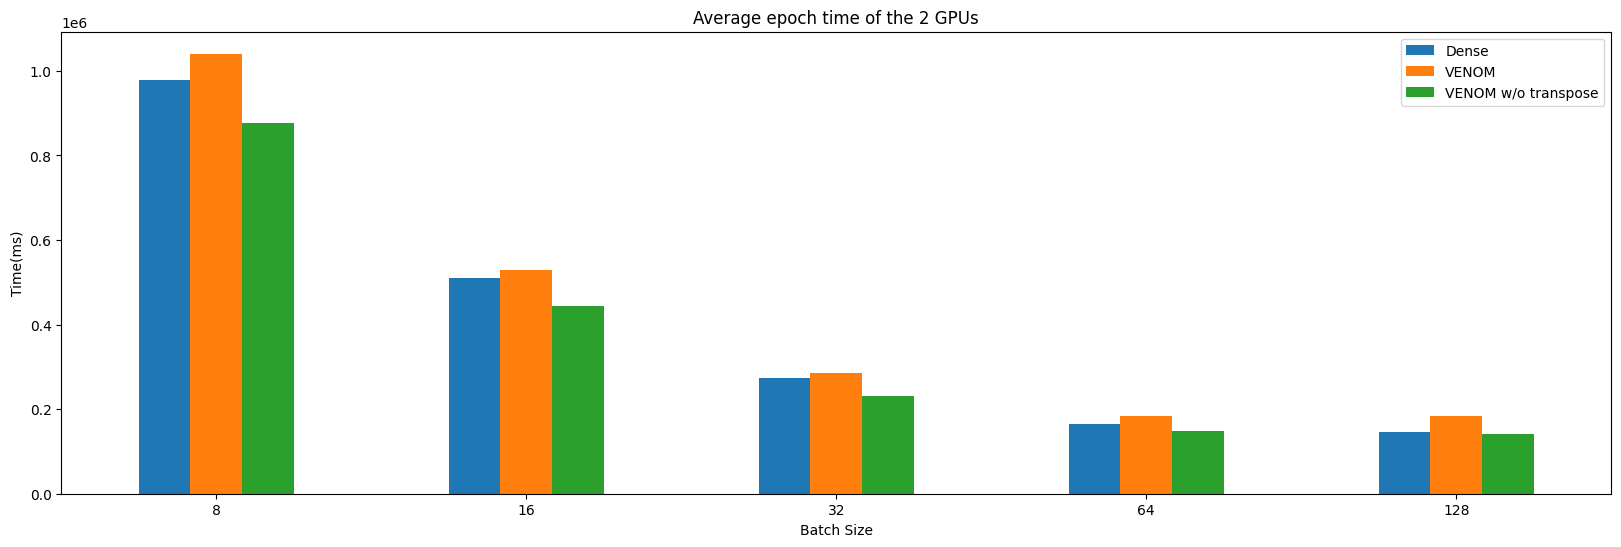

In [44]:
# Draw graph.
#fig, ax = plt.subplots(figsize=(20, 6))
ax = df.plot(kind='bar', rot=0, figsize=(20, 6))

#tick_location = range(1, 6)

# plot series
#ax.plot(dense, batch_sizes, color='r', label='Dense kernels')
#dense_bars = ax.bar(tick_location, dense['step_time_mean'], label='Dense kernels')
#dense_bars = ax.bar(tick_location, venom['step_time_mean'], label='VENOM kernels')
#dense_bars = ax.bar(tick_location, venom_no_transpose['step_time_mean'], label='VENOM w/o Transpose kernels')
#ax.plot(venom, batch_sizes, color='g', label='VENOM kernels')
#ax.plot(venom_no_transpose, batch_sizes, color='b', label='VENOM kernels w/o transpose')



# Decorate graph
ax.set_ylabel('Time(ms)')
#ax.set_xlabel('Batch size')
ax.set_title('Average epoch time of the '+str(gpus)+' GPUs')
#ax.set_xticks(tick_location, dense['bs'])
#ax.legend(loc='upper right')
plt.savefig(figname, bbox_inches='tight')